---
# Texas Used Cars Regression Project
---

Adam Talbot - 10.14.21

<img src="https://s19538.pcdn.co/wp-content/uploads/2018/08/Car-Gurus-Logo.jpg" alt="Car Gurus" title="Car Gurus Logo" width="600" height="300" />

---
## Executive Summary
---

**Goals:**
- Find predictors of sales price for used cars in Texas
- Construct a ML regression model that accurately predicts sales price
- Complete end-to-end ML project encompassing all phases of DS pipeline
- Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report
- Create modules as necessary that make my process repeateable
- Include all work in github repo with README to provide high level overview and instructions for replication

**Conclusions/Takaways:**
- The best drivers identified were:
    - `back_legroom`
    - `city_fuel_economy`
    - `engine_displacement`
    - `fuel_tank_volume`
    - `height`
    - `highway_fuel_economy`
    - `horsepower`
    - `length`
    - `maximum_seating`
    - `mileage`
    - `wheelbase`
    - `width`
    - `year`
- Best-peforming model outperformed basline by:
    - Having an **RMSE** value that was **\$9,172 less**
    - **R$^2$** improvement over baseline from **0 to 0.89**

**Next Steps/Recommendations:**
- Try more combinations of categorical features to see if I can optimize performance
- Do more nuanced imputation using means/modes of subgroups instead of just means/modes of whole population
- Try less imputation and see how that affects model performance (drop more nulls)

---
## Plan
---

- [x] Create README.md with data dictionary, project and business goals, come up with initial hypotheses.
- [x] Acquire data from Kaggle, save to local .csv and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
- [x] Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- [x] Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- [x] Establish a baseline accuracy and document well.
- [x] Train several different regression models.
- [x] Evaluate models on train and validate datasets.
- [x] Choose the model with that performs the best and evaluate that single model on the test dataset.
- [x] Document conclusions, takeaways, and next steps in the Final Report Notebook.
- [x] Iterate back through the pipeline imporving each phase as time permits

---
## Imports
---

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# Custom module imports
import acquire as a
import prepare as p
import explore as ex
import evaluate as ev

# plotting settings
plt.rc('font', size=12)
plt.rc('figure', figsize=(15, 7))
pd.options.display.float_format = '{:.2f}'.format
sns.set_palette('colorblind')

---
## Acquire
---

In [2]:
# use function from wrangle module to acquire needed data, see wrangle.py for code
df = a.get_tx_car_data()

In [3]:
df.head(1)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
139229,JHMFC1F73JX018575,37.4 in,NaN,NaN,NaN,Sedan,NaN,Fort Worth,32.00,NaN,...,CVT,Continuously Variable Transmission,t76411,Touring,NaN,FWD,Front-Wheel Drive,106.3 in,70.8 in,2018


In [4]:
df.shape

(122842, 66)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122842 entries, 139229 to 2980594
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   vin                      122842 non-null  object 
 1   back_legroom             116941 non-null  object 
 2   bed                      1203 non-null    object 
 3   bed_height               17927 non-null   object 
 4   bed_length               17927 non-null   object 
 5   body_type                122379 non-null  object 
 6   cabin                    2139 non-null    object 
 7   city                     122842 non-null  object 
 8   city_fuel_economy        103714 non-null  float64
 9   combine_fuel_economy     0 non-null       float64
 10  daysonmarket             122842 non-null  int64  
 11  dealer_zip               122842 non-null  int64  
 12  description              119356 non-null  object 
 13  engine_cylinders         118750 non-null  object 
 14

In [6]:
df.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,103714.00,0.00,122842.00,122842.00,116188.00,103714.00,116188.00,0.00,122842.00,122842.00,122842.00,118019.00,57388.00,122842.00,122842.00,121225.00,122840.00,0.00,122842.00
mean,22.54,NaN,75.97,75935.20,3026.09,29.53,252.43,NaN,30.93,275576840.39,-97.02,32451.25,1.60,30404.03,535.88,4.17,248532.83,NaN,2017.84
std,7.94,NaN,108.94,8375.06,1379.42,7.27,93.18,NaN,2.09,8932005.95,3.96,294877.53,0.96,21050.97,1163.12,0.49,124841.16,NaN,3.92
min,9.00,NaN,0.00,2476.00,700.00,10.00,67.00,NaN,29.29,78109827.00,-122.18,0.00,1.00,800.00,0.00,1.00,48660.00,NaN,1923.00
25%,18.00,NaN,15.00,76177.00,2000.00,25.00,175.00,NaN,29.65,274573406.50,-98.36,6.00,1.00,17998.00,0.00,3.90,66121.00,NaN,2017.00
50%,21.00,NaN,36.00,77074.00,2500.00,29.00,248.00,NaN,29.93,278566366.00,-96.90,3256.00,1.00,26090.00,0.00,4.23,284583.00,NaN,2020.00
75%,26.00,NaN,83.00,78238.00,3600.00,33.00,310.00,NaN,32.65,280501883.75,-95.55,44515.00,2.00,38995.00,732.00,4.50,338645.00,NaN,2020.00
max,127.00,NaN,2416.00,98223.00,8300.00,127.00,903.00,NaN,48.15,281950010.00,-71.17,99999988.00,10.00,1750000.00,130021.00,5.00,440798.00,NaN,2021.00


### Takeaways:
- Have some outliers/erroneous data in several numeric columns
- Lots of nulls in several columns
- Some columns may be redudant
- I am starting with a df with a shape of (122842, 66)
- Description of initial data pull:
    - Only pulled records for cars sold in the 7 largest cities (population) in TX
        - Houston, San Antonio, Dallas, Austin, El Paso, Arlington, and Fort Worth

---
## Prepare
---

### Clean

In [7]:
# use function to clean data, see prepare.py for code
df = p.clean_cars(df)

In [8]:
# create lists of cat_cols and num_cols for future use
cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = df.select_dtypes('number').columns.tolist()

---
### Split

In [9]:
# split data with nulls intact before doing any imputation
train_all, validate_all, test_all = p.split_80(df)

Train Proportion: 0.80 (98375 rows)
Validate Proportion: 0.10 (12159 rows)    
Test Proportion: 0.10 (12282 rows)


---
### Imputation

In [10]:
# impute all missing values for all sets using train to find values
train_imputed, validate_imputed, test_imputed = p.impute(train_all, validate_all, test_all)

---
### Remove Outliers

In [11]:
# make list of columns with outliers
cols_w_outliers = [
    'back_legroom', 
    'city_fuel_economy', 
    'engine_displacement', 
    'front_legroom',
    'fuel_tank_volume',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'length',
    'maximum_seating',
    'mileage',
    'price',
    'wheelbase',
    'width',
    'year']

In [12]:
# remove outliers
train_exp, validate_exp, test_exp = p.remove_outliers(train_imputed, validate_imputed, test_imputed, cols_w_outliers, 2)

---
### Encode and Scale for Modeling

In [13]:
# encode each split
train_mod = pd.get_dummies(data=train_exp, columns=cat_cols)
validate_mod = pd.get_dummies(data=validate_exp, columns=cat_cols)
test_mod = pd.get_dummies(data=test_exp, columns=cat_cols)

In [14]:
# scale each split
cols_to_scale = [
    'back_legroom',
    'city_fuel_economy',
    'engine_displacement',
    'front_legroom',
    'fuel_tank_volume',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'latitude',
    'length',
    'longitude',
    'maximum_seating',
    'mileage',
    'wheelbase',
    'width',
    'year']

In [15]:
train_mod_scaled, val_mod_scaled, test_mod_scaled = p.scale(train_mod, validate_mod, test_mod, MinMaxScaler(), cols_to_scale)

---

#### Preparation Performed:
- Reset index for subset of data selected from raw data
- Dropped duplicate rows
- Dropped all columns and rows with more than 50% of data missing
- Pulled numbers from strings for various measurement columns
- Converted boolean columns to Yes or No
- Simplified some columns with many categories by adding "Other" category
- Dropped columns that had too many columns, were redundant, or weren't useful for my objectives with this project
- Imputed remaining null values using mean or median for continuous variables and mode for categorical variables
- Removed outliers for columns where needed using Tukey's Method and a k-value of 2
- Made splits for exploration and splits for modeling (encoded and scaled)

---
## Explore 
---

### Univariate

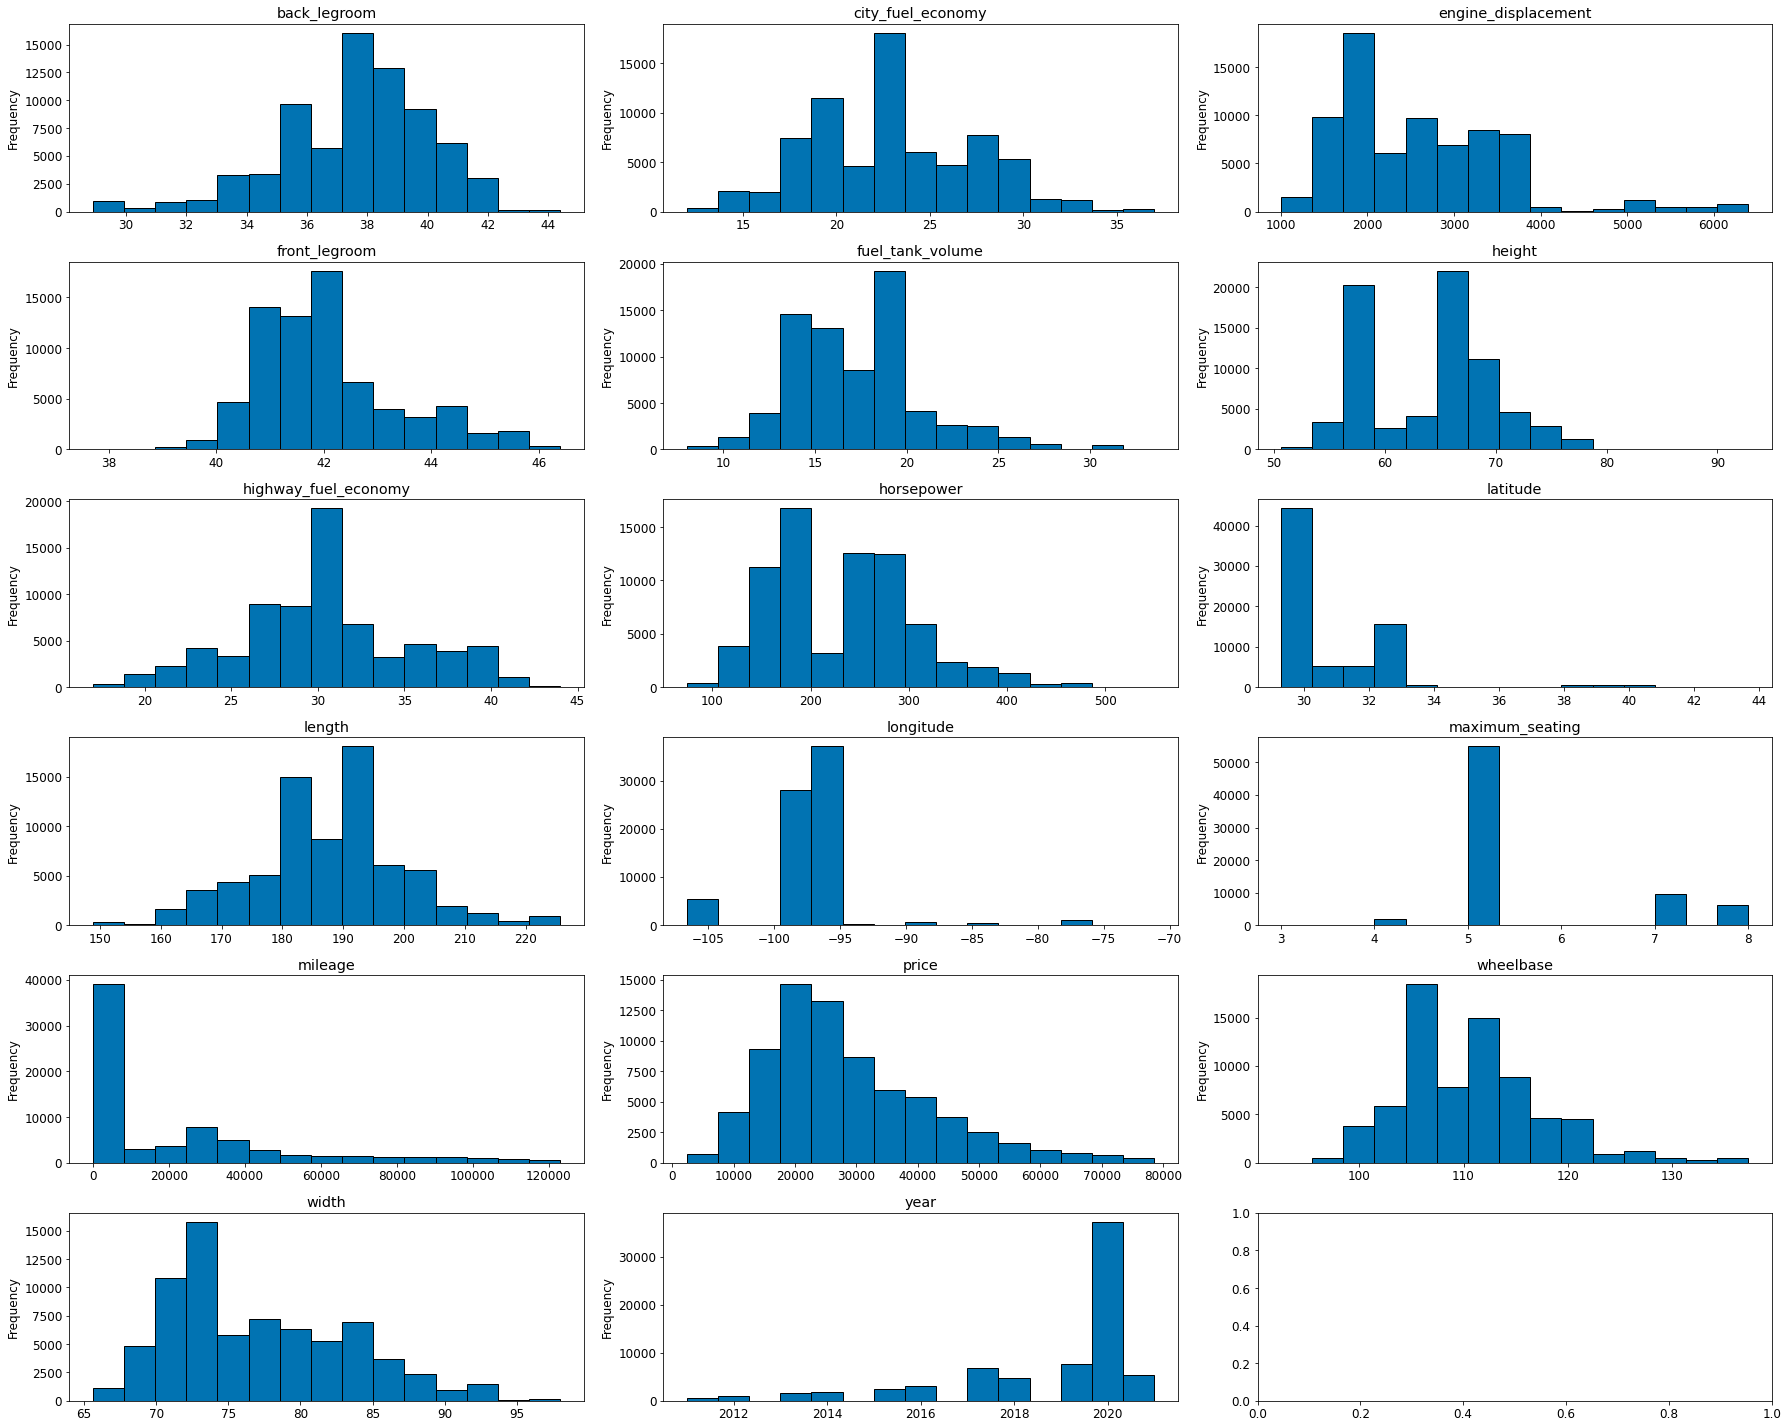

In [16]:
# let's take a quick look at the distributions of the continuous variables
fig, axs = plt.subplots(6, 3, sharey=False, figsize=(25, 20))
axe = axs.ravel()
for i, c in enumerate(num_cols):
    train_exp[c].plot.hist(ax=axe[i],title=c, ec='black', bins=15)
    plt.tight_layout()

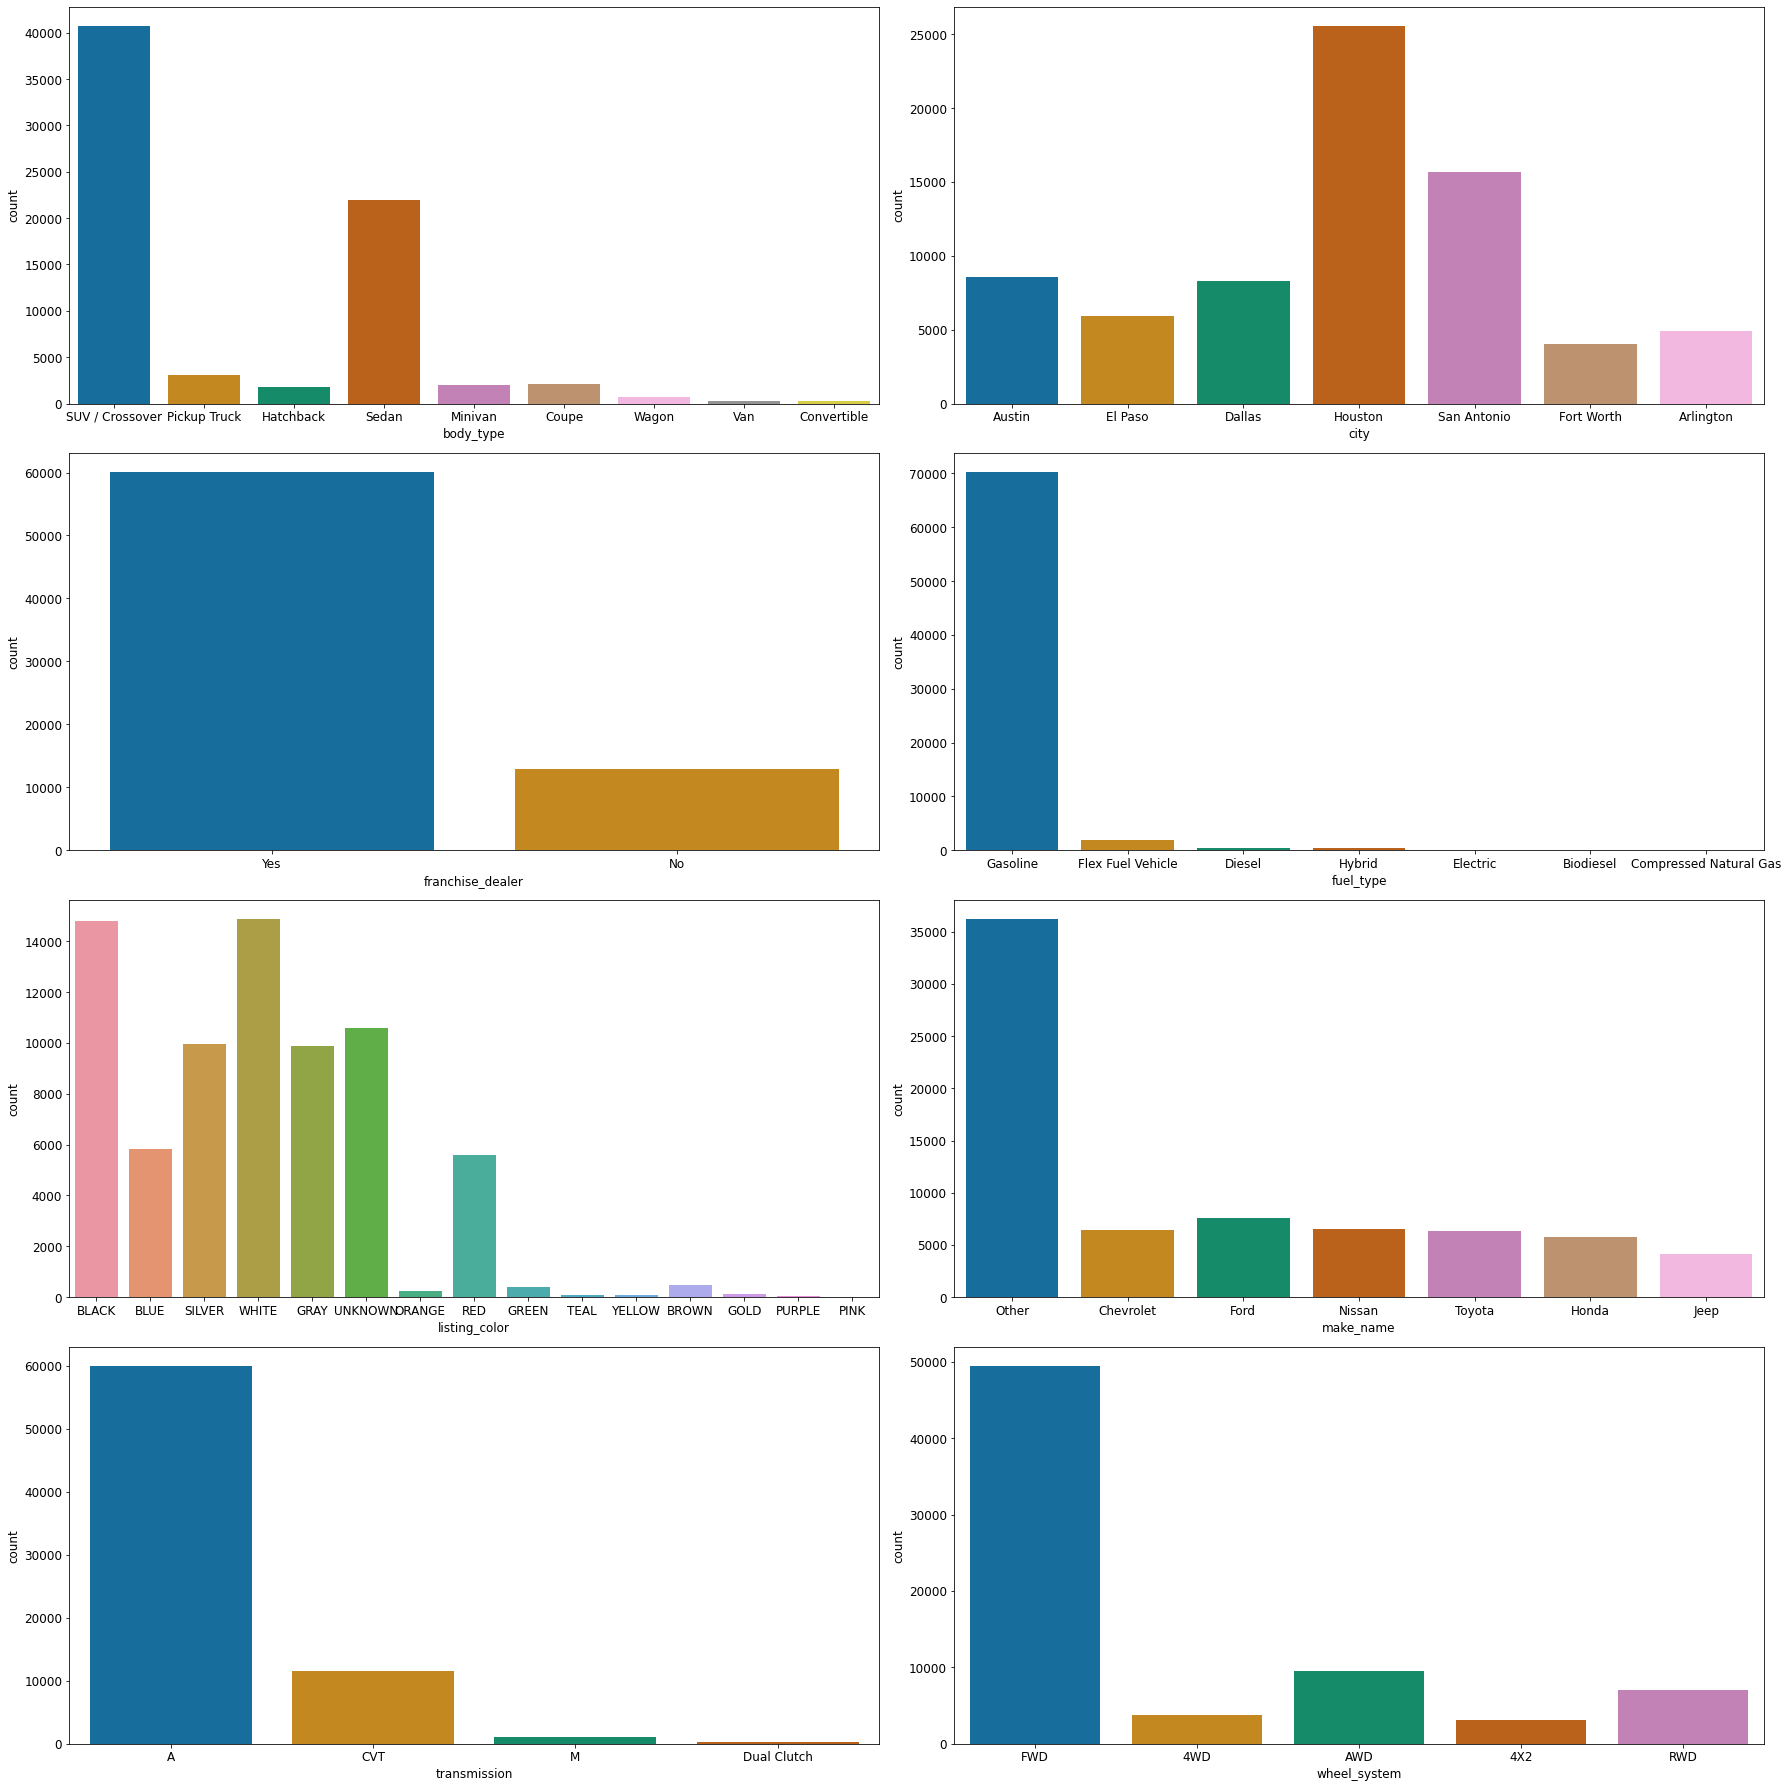

In [17]:
# let's take a quick look at the count plots for each categorical variable
fig, axs = plt.subplots(4, 2, sharey=False, figsize=(25, 25))
axe = axs.ravel()
for i, c in enumerate(cat_cols):
    # train_exp[c].plot.hist(ax=axe[i],title=c, ec='black', bins=15)
    sns.countplot(train_exp[c], ax=axe[i])
    plt.tight_layout()

#### Takeaways:
- Outliers were removed successfully
- Some distributions look normal, some not as much
- Will use parametric and non-parametric tests accordingly

---
### Bivariate
---

#### Continuous with Target
---

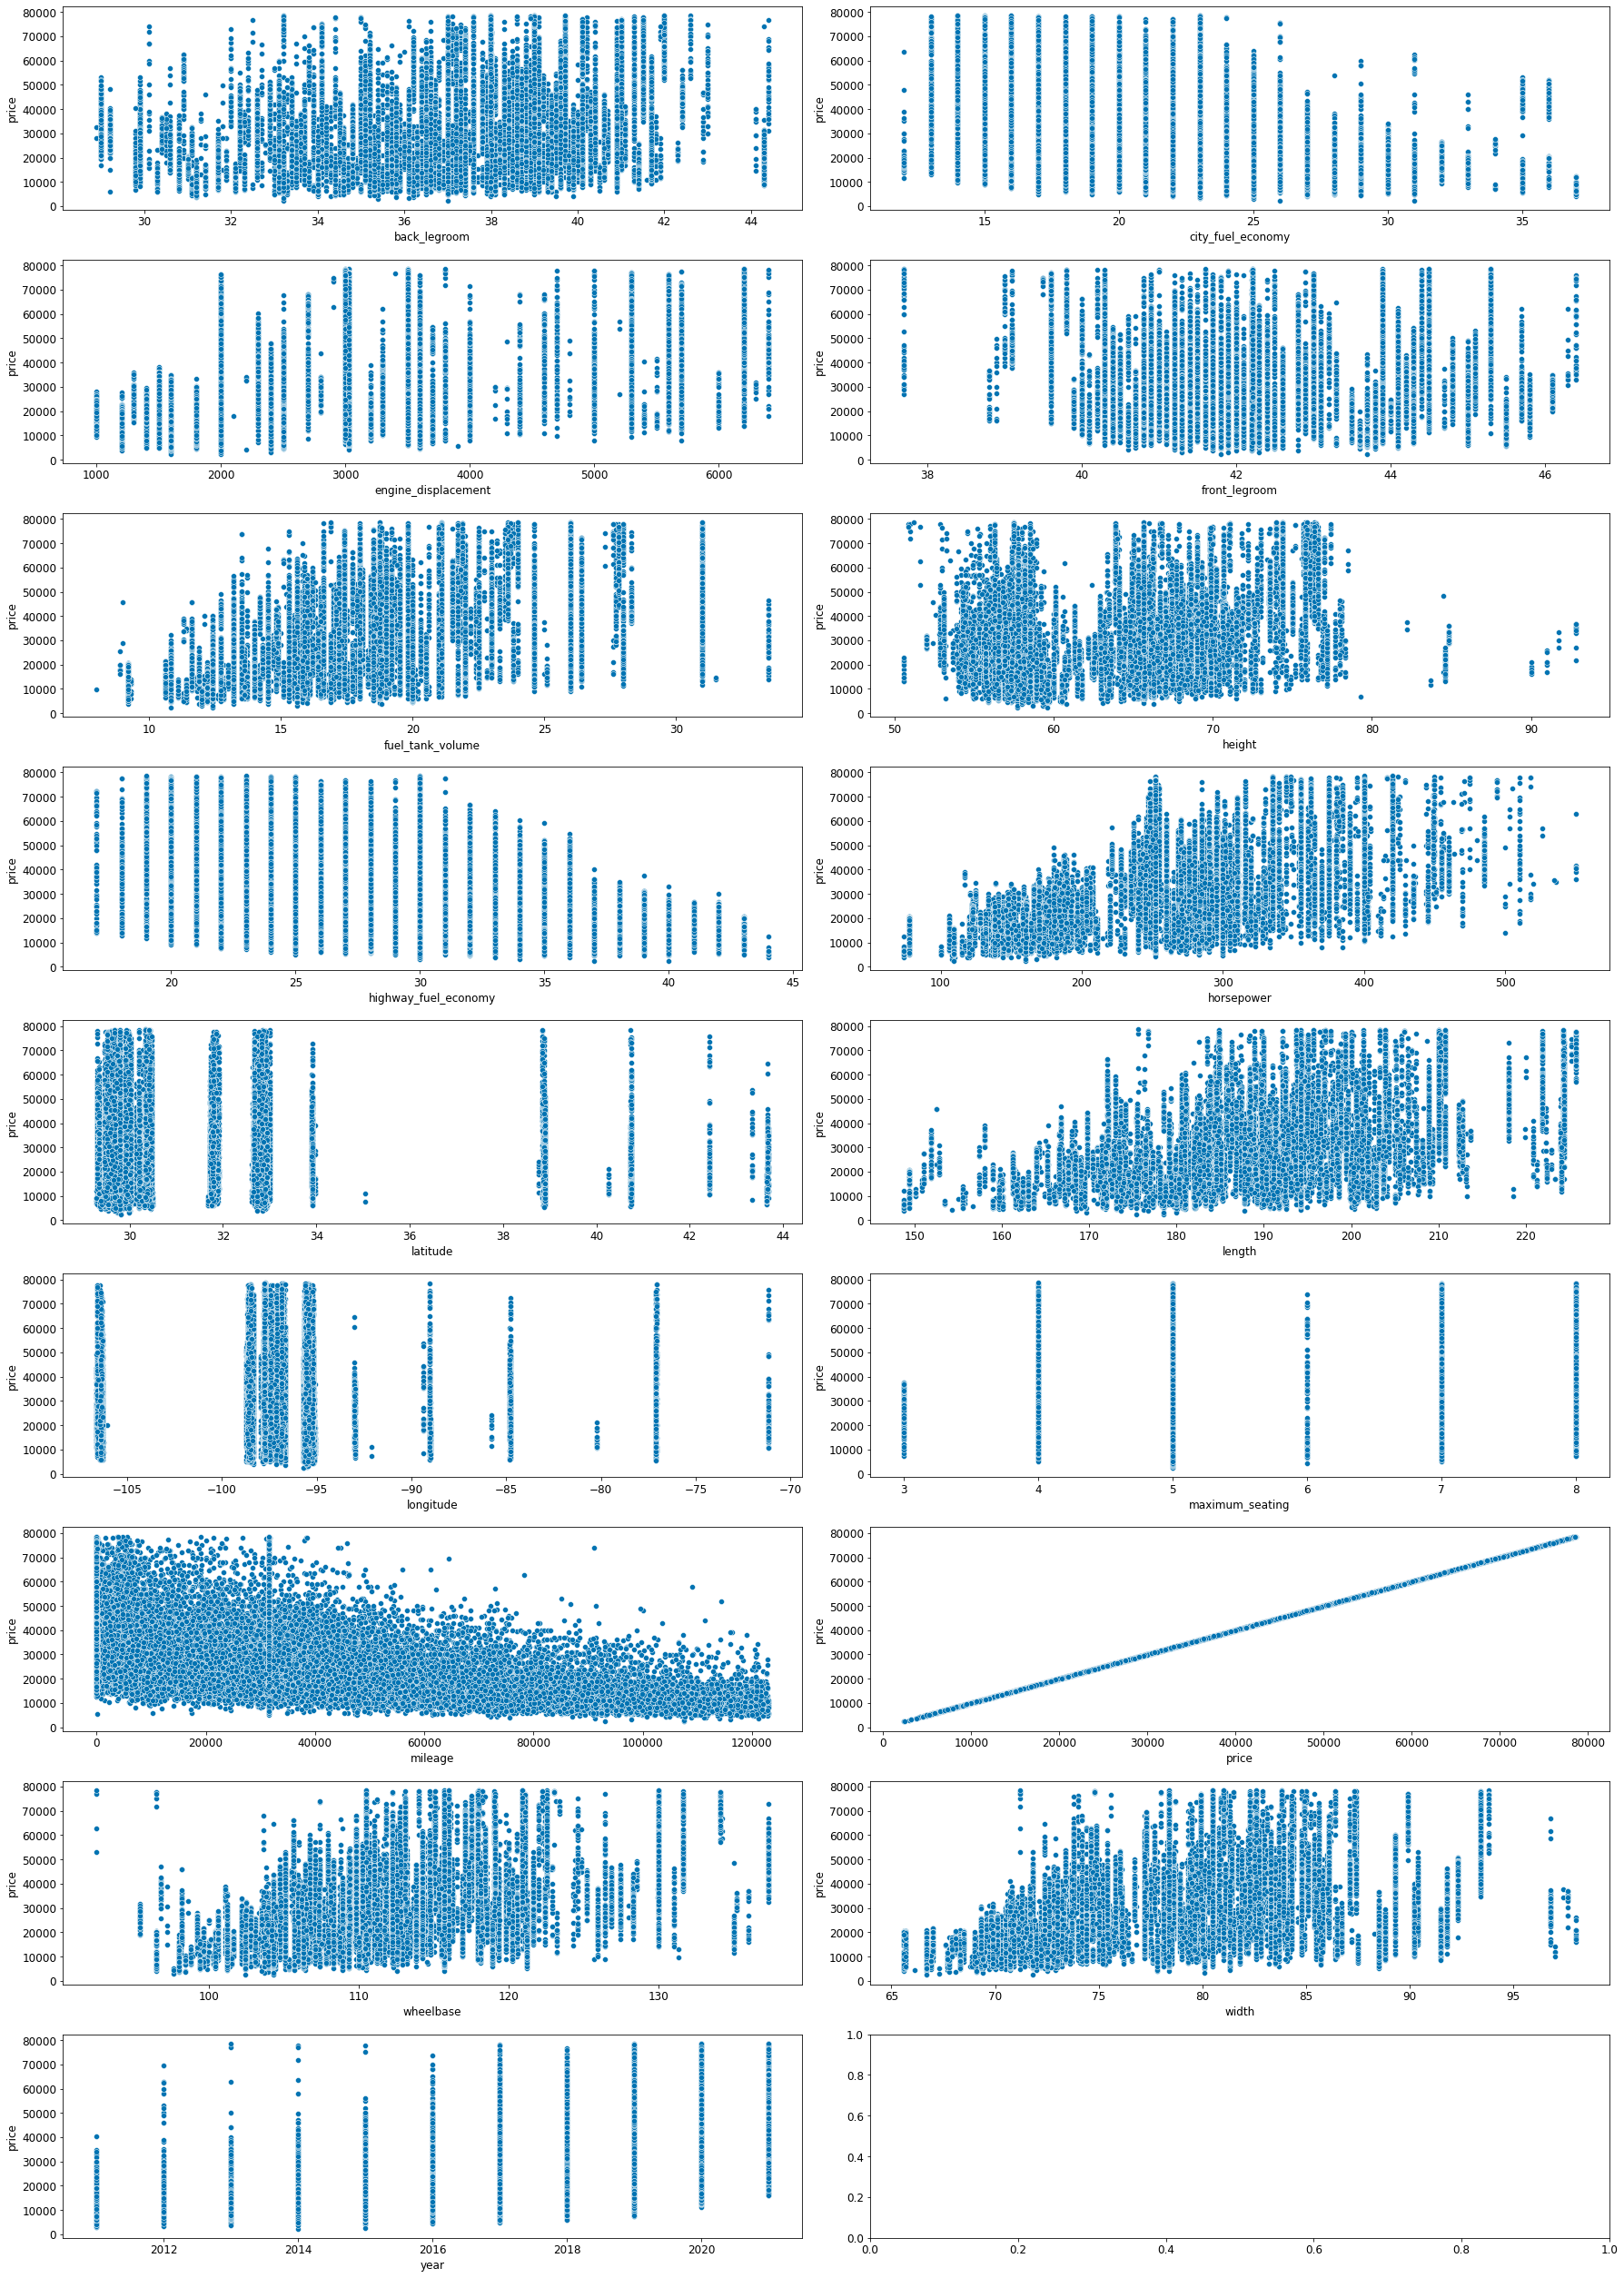

In [18]:
# let's take a look at all other continuous variables compared to target
fig, axs = plt.subplots(9, 2, sharey=False, figsize=(25, 35))
axe = axs.ravel()
for i, c in enumerate(num_cols):
    sns.scatterplot(x=train_exp[c], y=train_exp.price, ax=axe[i])
    plt.tight_layout()

##### Takeaways:
- Positive correlations between price and:
    - back legroom
    - engine displacement
    - fuel tank volume
    - horsepower
    - length
    - maximum seating
    - wheelbase
    - width
    - year
- Negative correlations between price and:
    - city fuel economy
    - highway fuel economy
    - mileage

In [19]:
# # heatmap of correlations for all columns
# plt.figure(figsize=(20, 20))
# heatmap = sns.heatmap(train_exp.corr(method='spearman'), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0)
# heatmap.set_title('Correlation Heatmap for Predictors and Target', pad=16);

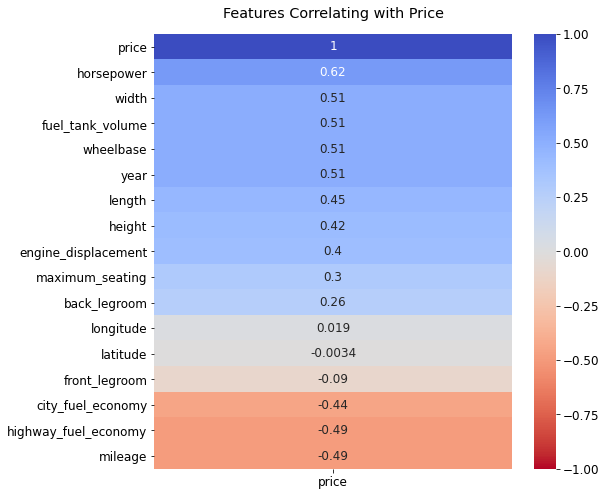

In [20]:
# heatmap of correlations for features and target
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(train_exp[num_cols].corr(method='spearman')[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1 );
heatmap.set_title('Features Correlating with Price', pad=16);

---
##### Spearman's R Tests

$H_0$: There is no correlation between the each of the continuous variables and price.

$H_a$: There is a correlation between the each of the continuous variables and price.

$\alpha$ = 0.01

In [21]:
print(f"Spearman's Correlation Coefficient Test results:\n")
for col in num_cols:
    r, p = stats.spearmanr(train_exp.price, train_exp[col])
    print(f'price vs {col}:\nr = {r:.2f}\np = {p:.3f}\n')
    if p < 0.01:
        print(f'We REJECT the null hypothesis, there is a correlation between {col} and price.\n')
    else:
        print(f'We FAIL TO REJECT the null hypothesis, there is not a correlation between {col} and price.\n')

Spearman's Correlation Coefficient Test results:

price vs back_legroom:
r = 0.26
p = 0.000

We REJECT the null hypothesis, there is a correlation between back_legroom and price.

price vs city_fuel_economy:
r = -0.44
p = 0.000

We REJECT the null hypothesis, there is a correlation between city_fuel_economy and price.

price vs engine_displacement:
r = 0.40
p = 0.000

We REJECT the null hypothesis, there is a correlation between engine_displacement and price.

price vs front_legroom:
r = -0.09
p = 0.000

We REJECT the null hypothesis, there is a correlation between front_legroom and price.

price vs fuel_tank_volume:
r = 0.51
p = 0.000

We REJECT the null hypothesis, there is a correlation between fuel_tank_volume and price.

price vs height:
r = 0.42
p = 0.000

We REJECT the null hypothesis, there is a correlation between height and price.

price vs highway_fuel_economy:
r = -0.49
p = 0.000

We REJECT the null hypothesis, there is a correlation between highway_fuel_economy and price.


##### Takeaways:
- All other continuous variables have a statistically significant correlation with price
- All continuous variables with a correlation coefficient >= 0.2 will be included in model

---
#### Categorical with Target
---

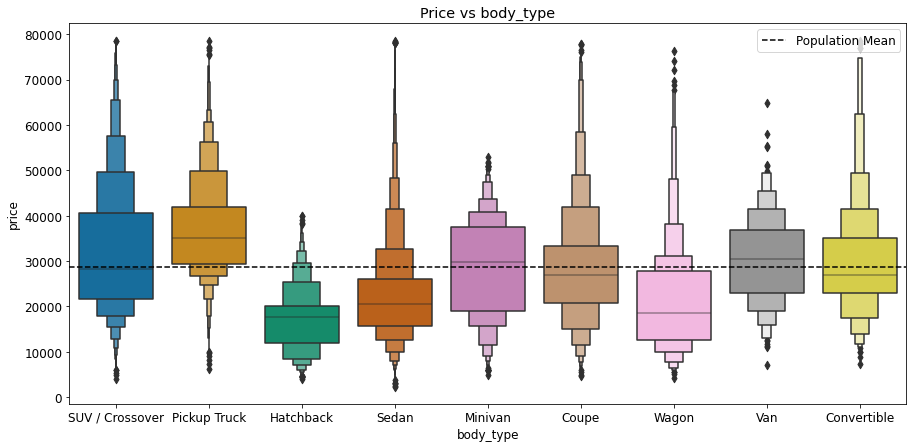

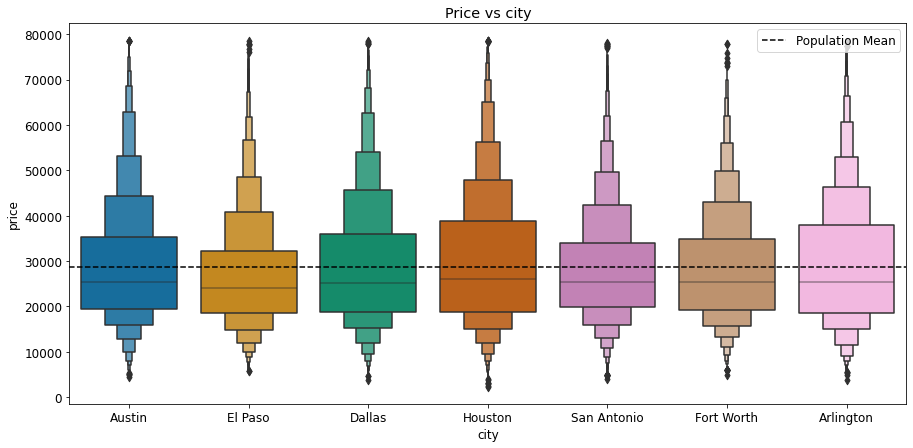

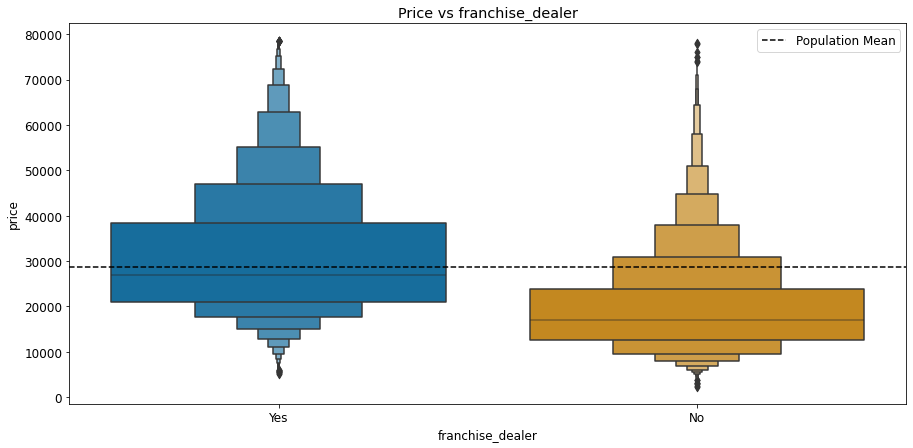

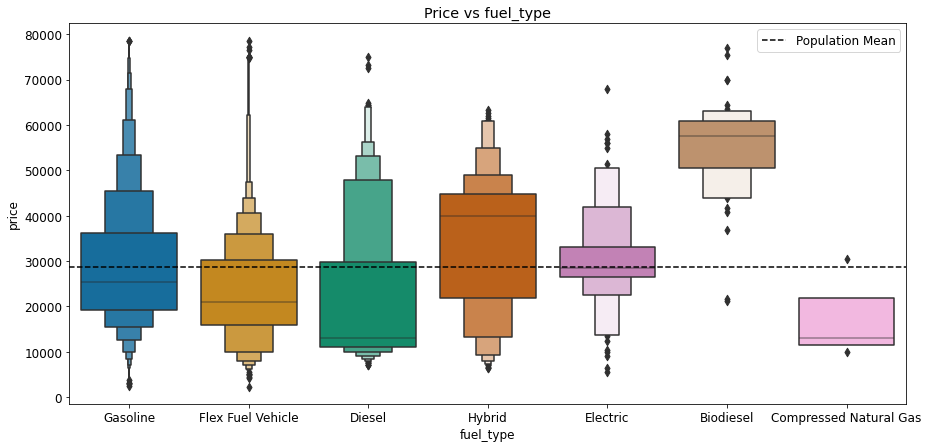

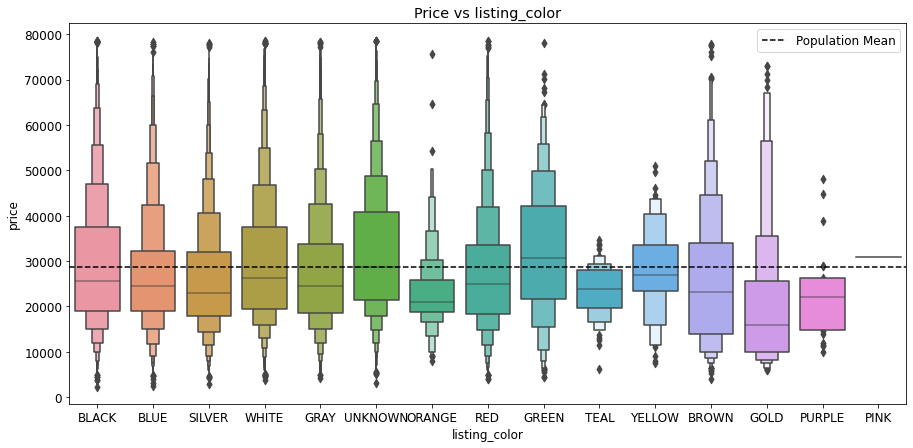

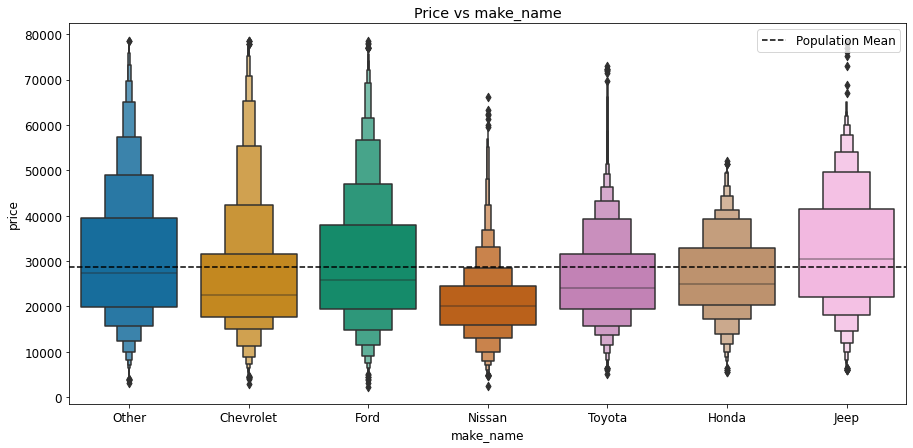

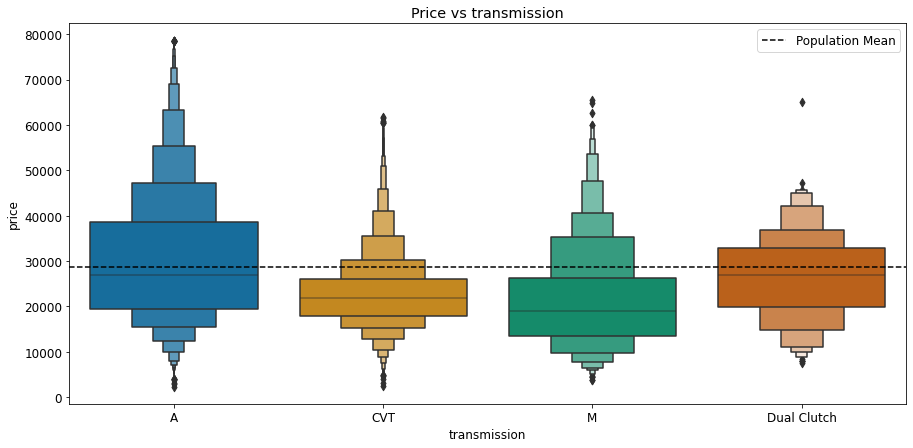

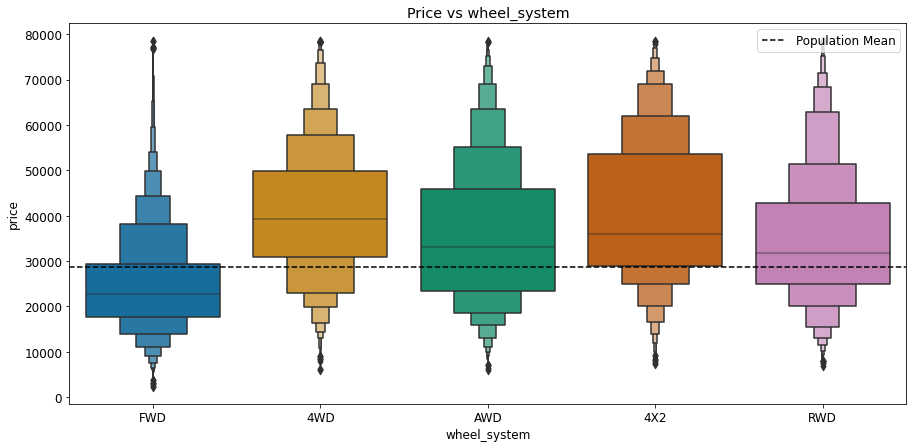

In [22]:
for col in cat_cols:
    sns.boxenplot(x=train_exp[col], y=train_exp.price)
    plt.axhline(train_exp.price.mean(), ls='--', color='black', label='Population Mean')
    plt.title(f'Price vs {col}')
    plt.legend(loc='upper right')
    plt.show()

---
##### Kruskal-Wallis H-Tests

$H_0$: The median price of all of the groups are equal for each categorical variable.

$H_a$: The median price of all of the groups are not equal for each categorical variable.

$\alpha$ = 0.01

In [23]:
# couldn't get this all the way into a function, wanted to get all category subsets into stat.kruskal arguments
cat = 'body_type'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]],
    train_exp.price[train_exp[cat] == group_list[5]],
    train_exp.price[train_exp[cat] == group_list[6]],
    train_exp.price[train_exp[cat] == group_list[7]],
    train_exp.price[train_exp[cat] == group_list[8]]
)

print(f"Kruskal-Wallis Test Results:\n")

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')

    
cat = 'city'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]],
    train_exp.price[train_exp[cat] == group_list[5]],
    train_exp.price[train_exp[cat] == group_list[6]],
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')

    
cat = 'franchise_dealer'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]]
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
   

cat = 'fuel_type'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]],
    train_exp.price[train_exp[cat] == group_list[5]],
    train_exp.price[train_exp[cat] == group_list[6]],
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
   

cat = 'listing_color'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]],
    train_exp.price[train_exp[cat] == group_list[5]],
    train_exp.price[train_exp[cat] == group_list[6]],
    train_exp.price[train_exp[cat] == group_list[7]],
    train_exp.price[train_exp[cat] == group_list[8]],
    train_exp.price[train_exp[cat] == group_list[9]],
    train_exp.price[train_exp[cat] == group_list[10]],
    train_exp.price[train_exp[cat] == group_list[11]],
    train_exp.price[train_exp[cat] == group_list[12]],
    train_exp.price[train_exp[cat] == group_list[13]],
    train_exp.price[train_exp[cat] == group_list[14]]
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
    
    
cat = 'make_name'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]],
    train_exp.price[train_exp[cat] == group_list[5]],
    train_exp.price[train_exp[cat] == group_list[6]]
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
    
    
cat = 'transmission'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]]
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
    
    
cat = 'wheel_system'
group_list = []

for group, values in train_exp.groupby(cat):
    group_list.append(group)

H, p = stats.kruskal(
    train_exp.price[train_exp[cat] == group_list[0]],
    train_exp.price[train_exp[cat] == group_list[1]],
    train_exp.price[train_exp[cat] == group_list[2]],
    train_exp.price[train_exp[cat] == group_list[3]],
    train_exp.price[train_exp[cat] == group_list[4]]
)

print(f'price vs {cat}:\n\nH = {H:.2f}\np = {p:.3f}\n')

if p < 0.01:
    print(f'We REJECT the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')
else:
    print(f'We FAIL TO REJECT reject the null hypothesis, the median price of all of the groups are not equal for {cat}.\n')

Kruskal-Wallis Test Results:

price vs body_type:

H = 12199.03
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for body_type.

price vs city:

H = 161.82
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for city.

price vs franchise_dealer:

H = 9286.63
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for franchise_dealer.

price vs fuel_type:

H = 699.18
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for fuel_type.

price vs listing_color:

H = 1500.40
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for listing_color.

price vs make_name:

H = 3985.69
p = 0.000

We REJECT the null hypothesis, the median price of all of the groups are not equal for make_name.

price vs transmission:

H = 2849.54
p = 0.000

We REJECT the null hypothesis, the median price of all

##### Takeaways:
- All of these categorical features have a relationship with price, we will investigate further to see which categories specifically have a different mean price than the population

---
##### One-Sample T-Tests

$H_0$: The mean price for each of the categorical groups is the same as overall population average.

$H_a$: The mean price for each of the categorical groups is not the same as overall population average.

$\alpha$ = 0.01

In [24]:
print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~\nOne-sample T-Test Results\n~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
for col in cat_cols:
    print(f'===================\n{col}\n===================\n')
    ex.group_stats(train_exp, 'price', col)

~~~~~~~~~~~~~~~~~~~~~~~~~~~
One-sample T-Test Results
~~~~~~~~~~~~~~~~~~~~~~~~~~~

body_type

----------------
Convertible
----------------
T-Statistic: 1.51
P-value: 0.132
We FAIL TO REJECT the null hypothesis, the mean price for the Convertible subset is not different than the overall population mean.

----------------
Coupe
----------------
T-Statistic: -1.29
P-value: 0.199
We FAIL TO REJECT the null hypothesis, the mean price for the Coupe subset is not different than the overall population mean.

----------------
Hatchback
----------------
T-Statistic: -69.51
P-value: 0.000
We REJECT the null hypothesis, the mean price for the Hatchback subset is different than the overall population mean.

----------------
Minivan
----------------
T-Statistic: -0.47
P-value: 0.639
We FAIL TO REJECT the null hypothesis, the mean price for the Minivan subset is not different than the overall population mean.

----------------
Pickup Truck
----------------
T-Statistic: 42.85
P-value: 0.000
We REJECT

##### Takeaways:
- All categories where we were able to reject the null hypothesis are related to price and will be further investigated to see if they should be used in modeling

---
### X and y (keeping everything for feature analysis)

In [25]:
# split into X and y for all splits
X_train = train_mod_scaled.drop(columns='price')
y_train = train_mod_scaled.price
X_validate = val_mod_scaled.drop(columns='price')
y_validate = val_mod_scaled.price
X_test = test_mod_scaled.drop(columns='price')
y_test = test_mod_scaled.price

---
### Additional Feature Analysis
---

#### SelectKBest

In [26]:
ex.select_kbest(X_train, y_train, 15)

['franchise_dealer_No',
 'franchise_dealer_Yes',
 'wheel_system_FWD',
 'city_fuel_economy_scaled',
 'engine_displacement_scaled',
 'fuel_tank_volume_scaled',
 'height_scaled',
 'highway_fuel_economy_scaled',
 'horsepower_scaled',
 'length_scaled',
 'maximum_seating_scaled',
 'mileage_scaled',
 'wheelbase_scaled',
 'width_scaled',
 'year_scaled']

##### Takeway:
- Most of top features here are numerical variables

---
#### RFE

In [27]:
ex.show_rfe_feature_ranking(X_train, y_train).head(15)

wheel_system_4X2                     1
wheel_system_4WD                     2
wheel_system_AWD                     3
wheel_system_RWD                     4
wheel_system_FWD                     5
make_name_Other                      6
make_name_Honda                      7
make_name_Ford                       8
make_name_Toyota                     9
make_name_Jeep                      10
make_name_Chevrolet                 11
make_name_Nissan                    12
fuel_type_Compressed Natural Gas    13
fuel_type_Diesel                    14
fuel_type_Flex Fuel Vehicle         15
dtype: int64

##### Takeway:
- Categorical variables are being ranked higher with this method

---
### Explore Takeaways:
- All continuous variables with correlation coefficient > 0.2 and a few of the top categorical variables (highest tests statistics) will further investigated via modeling

---
## Model/Evaluate
---

In [28]:
# set target variable to reduce code debt
target = 'price'

---
### X and y

In [29]:
# remove continuous variables with correlation coefficients less than 0.2
cols_to_scale.remove('latitude')
cols_to_scale.remove('longitude')
cols_to_scale.remove('front_legroom')

features_for_model = [col + '_scaled' for col in cols_to_scale]

In [30]:
# split into X and y for all splits
X_train = train_mod_scaled[features_for_model]
y_train = train_mod_scaled[target]
X_validate = val_mod_scaled[features_for_model]
y_validate = val_mod_scaled[target]
X_test = test_mod_scaled[features_for_model]
y_test = test_mod_scaled[target]

---
### Target Distribution

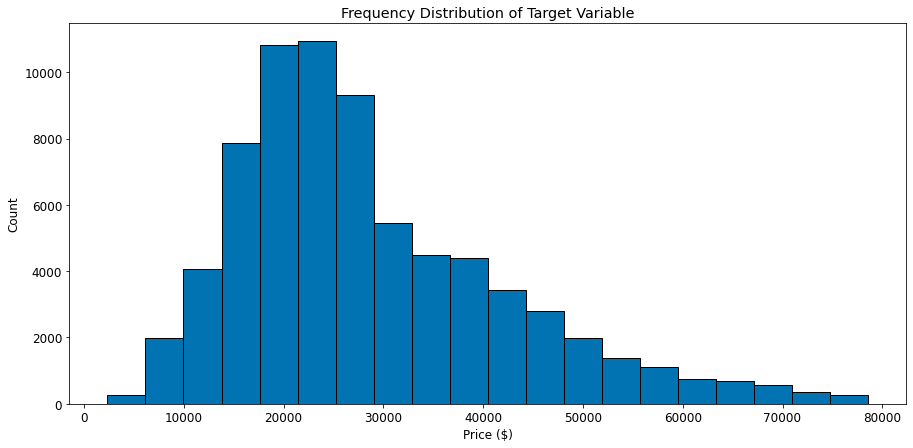

In [31]:
plt.hist(y_train, edgecolor='black', bins=20)
plt.title('Frequency Distribution of Target Variable')
plt.xlabel('Price ($)')
plt.ylabel('Count');

#### Takeaway:
 - Not completely normal, this could inform our model algorithm selection decision

---
### Baseline

In [32]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict baseline_mean
baseline_mean = y_train[target].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

# Predict baseline_median
baseline_median = y_train[target].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median

In [33]:
# create empty df to start appending to
metric_df = pd.DataFrame()

In [34]:
# get metrics for baseline mean model
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.baseline_mean, 
                           y_validate[target], 
                           y_validate.baseline_mean, 
                           'Baseline Mean', 
                           metric_df)

In [35]:
# get metrics for baseline median model
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.baseline_median, 
                           y_validate[target], 
                           y_validate.baseline_median, 
                           'Baseline Median', 
                           metric_df)

---
### LinearRegression (OLS)

In [36]:
# make model
ols = LinearRegression(normalize=True)

# fit model
ols.fit(X_train, y_train[target])

# Make prediction for train and validate
y_train['ols_y_pred'] = ols.predict(X_train)
y_validate['ols_y_pred'] = ols.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.ols_y_pred, 
                           y_validate[target], 
                           y_validate.ols_y_pred, 
                           'OLS', 
                           metric_df)

---
### LassoLars

In [37]:
# create the model
lars = LassoLars(alpha=0.1)

# fit the model
lars.fit(X_train, y_train[target])

# predict train
y_train['lars_y_pred_alpha_01'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_01'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lars_y_pred_alpha_01, 
                           y_validate[target], 
                           y_validate.lars_y_pred_alpha_01, 
                           'LassoLars Alpha 0.1', 
                           metric_df)

In [38]:
# create the model
lars = LassoLars(alpha=0.5)

# fit the model
lars.fit(X_train, y_train[target])

# predict train
y_train['lars_y_pred_alpha_05'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_05'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lars_y_pred_alpha_05, 
                           y_validate[target], 
                           y_validate.lars_y_pred_alpha_05, 
                           'LassoLars Alpha 0.5', 
                           metric_df)

In [39]:
# create the model
lars = LassoLars(alpha=1)

# fit the model
lars.fit(X_train, y_train[target])

# predict train
y_train['lars_y_pred_alpha_1'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_1'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lars_y_pred_alpha_1, 
                           y_validate[target], 
                           y_validate.lars_y_pred_alpha_1, 
                           'LassoLars Alpha 1', 
                           metric_df)

---
###  TweedieRegressor (GLM)

In [40]:
# create the model
glm = TweedieRegressor(power=0, alpha=0)

# fit the model
glm.fit(X_train, y_train[target])

# predict train
y_train['glm_y_pred_normal'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_normal'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.glm_y_pred_normal, 
                           y_validate[target], 
                           y_validate.glm_y_pred_normal, 
                           'GLM Normal', 
                           metric_df)

In [ ]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)

# fit the model
glm.fit(X_train, y_train[target])

# predict train
y_train['glm_y_pred_poisson'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_poisson'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.glm_y_pred_poisson, 
                           y_validate[target], 
                           y_validate.glm_y_pred_poisson, 
                           'GLM Poisson', 
                           metric_df)

In [ ]:
# create the model
glm = TweedieRegressor(power=1.5, alpha=0)

# fit the model
glm.fit(X_train, y_train[target])

# predict train
y_train['glm_y_pred_poisson_gamma'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_poisson_gamma'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.glm_y_pred_poisson_gamma, 
                           y_validate[target], 
                           y_validate.glm_y_pred_poisson_gamma, 
                           'GLM Poisson Gamma', 
                           metric_df)

In [ ]:
# create the model
glm = TweedieRegressor(power=2, alpha=0)

# fit the model
glm.fit(X_train, y_train[target])

# predict train
y_train['glm_y_pred_gamma'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_gamma'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.glm_y_pred_gamma, 
                           y_validate[target], 
                           y_validate.glm_y_pred_gamma, 
                           'GLM Gamma', 
                           metric_df)

In [ ]:
# create the model
glm = TweedieRegressor(power=3, alpha=0)

# fit the model
glm.fit(X_train, y_train[target])

# predict train
y_train['glm_y_pred_i_gauss'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_i_gauss'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.glm_y_pred_i_gauss, 
                           y_validate[target], 
                           y_validate.glm_y_pred_i_gauss, 
                           'GLM Inverse Gaussian', 
                           metric_df)

---
### Polynomial Regression

---
#### PolynomialFeatures

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate
X_validate_degree2 = pf.transform(X_validate)

In [ ]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate
X_validate_degree3 = pf3.transform(X_validate)

In [ ]:
# make the polynomial features to get a new set of features
pf4 = PolynomialFeatures(degree=4)

# fit and transform X_train
X_train_degree4 = pf4.fit_transform(X_train)

# transform X_validate
X_validate_degree4 = pf4.transform(X_validate)

---
#### LinearRegression

In [ ]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train[target])

# predict train
y_train['lm2_y_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['lm2_y_pred'] = lm2.predict(X_validate_degree2)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lm2_y_pred, 
                           y_validate[target], 
                           y_validate.lm2_y_pred, 
                           'Polynomial Regression Degree 2', 
                           metric_df)

In [ ]:
# create the model
lm3 = LinearRegression(normalize=True)

# fit the model
lm3.fit(X_train_degree3, y_train[target])

# predict train
y_train['lm3_y_pred'] = lm3.predict(X_train_degree3)

# predict validate
y_validate['lm3_y_pred'] = lm3.predict(X_validate_degree3)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lm3_y_pred, 
                           y_validate[target], 
                           y_validate.lm3_y_pred, 
                           'Polynomial Regression Degree 3', 
                           metric_df)

In [ ]:
%%time
# create the model
lm4 = LinearRegression(normalize=True)

# fit the model
lm4.fit(X_train_degree4, y_train[target])

# predict train
y_train['lm4_y_pred'] = lm4.predict(X_train_degree4)

# predict validate
y_validate['lm4_y_pred'] = lm4.predict(X_validate_degree4)

# get metrics
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.lm4_y_pred, 
                           y_validate[target], 
                           y_validate.lm4_y_pred, 
                           'Polynomial Regression Degree 4', 
                           metric_df)

In [ ]:
# Take a look at final metric df
metric_df

In [ ]:
# Make a plot to visualize results
sns.barplot(y=metric_df.sort_values(by='R2_validate', ascending=False).head(10)['R2_validate'], x=metric_df.sort_values(by='R2_validate', ascending=False).head(10)['model'])
plt.title('Model Comparison for Top Performing Models')
# plt.yticks(ticks=np.arange(0,1.1,0.1))
plt.ylabel('R$^2$')
plt.xlabel('Model Type')
plt.xticks(rotation=90);

In [ ]:
# Make a plot to visualize results
sns.barplot(y=metric_df.sort_values(by='RMSE_validate').head(10)['RMSE_validate'], x=metric_df.sort_values(by='RMSE_validate').head(10)['model'])
plt.title('Model Comparison for Top Performing Models')
plt.ylabel('RMSE ($)')
plt.xlabel('Model Type')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Make a plot to visualize results
sns.barplot(y=metric_df.sort_values('RMSE_diff').head(10)['RMSE_diff'], x=metric_df.sort_values('RMSE_diff').head(10)['model'])
plt.title('Which model(s) have smallest RMSE Difference from Train to Validate?', pad=16)
plt.xlabel('Models')
plt.ylabel('RMSE Difference')
plt.xticks(rotation=90);

#### Takeaway:
- Best peforming model Polynomial Regression with Degree 4

---
### Residual Plots

In [ ]:
# create residual plots
plt.figure(figsize=(20,5)).suptitle('Residual Plots for Best-Performing Model')

plt.subplot(121)

plt.plot(y_validate[target].sample(n=250, random_state=527), y_validate.baseline_mean.sample(n=250, random_state=527), alpha=0.5, color="gray", label='Baseline (mean)')
plt.plot(y_validate[target].sample(n=250, random_state=527), y_validate[target].sample(n=250, random_state=527), alpha=0.5, color="black", label='Predicted = Actual')

plt.scatter(y_validate[target].sample(n=250, random_state=527), y_validate.lm4_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=50, label="Model: Polynomial Regression Degree 4")

plt.legend()
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted for Best Performing Model")

plt.subplot(122)

plt.axhline(label="No Error", color='gray', alpha=0.5)
plt.scatter(y_validate[target].sample(n=250, random_state=527), (y_validate.lm4_y_pred - y_validate[target]).sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=50, label="Model: Polynomial Regression Degree 4")

plt.legend()
plt.xlabel("Actual Price ($)")
plt.ylabel("Residual/Error: Predicted Price - Actual Price ($)")
plt.title("Actual vs Residuals for Best Performing Model");

---
### Actual vs Predicted Distributions

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_train[target], color='gray', alpha=.25, label="Actual Price", bins=50)
plt.hist(y_train.lm4_y_pred, color='blue', alpha=.25, label="Model: Polynomial Regression Degree 4", bins=50)
plt.xlabel("Price ($)")
plt.ylabel("Number of Cars")
plt.title("Comparing the Distribution of Actual Prices to Distributions of Predicted Prices for the Top Model")
plt.legend()
plt.show()

---
### Evaluate Best-Performing Model on Test

In [ ]:
y_test = pd.DataFrame(y_test)
y_test['baseline_mean'] = y_train[target].mean()

X_test_degree4 = pf4.fit_transform(X_test)

# predict on test
y_test['lm4_y_pred'] = lm4.predict(X_test_degree4)

# evaluate: rmse
rmse_test = mean_squared_error(y_test[target], y_test.lm4_y_pred, squared=False)
r2_test = explained_variance_score(y_test[target], y_test.lm4_y_pred)
rmse_baseline = mean_squared_error(y_test[target], y_test.baseline_mean, squared=False)
r2_baseline = explained_variance_score(y_test[target], y_test.baseline_mean)

print(f'RMSE for Polynomial Regression Degree 4\nOut-of-Sample Performance: {rmse_test:.2f}\nR^2: {r2_test:.2f}')

# compare to baseline

print(f'\nMetrics for baseline:\nRMSE: {rmse_baseline:.3f}\nR^2: {r2_baseline:.3f}\n')

print(f'Model outperformed best baseline:\nRMSE difference: {rmse_test - rmse_baseline:.2f}\nR^2 difference: \
{(r2_test - r2_baseline):.2f}')

---
## Conclusions and Next Steps
---

**Conclusions/Takaways:**
- The best drivers identified were:
    - `back_legroom`
    - `city_fuel_economy`
    - `engine_displacement`
    - `fuel_tank_volume`
    - `height`
    - `highway_fuel_economy`
    - `horsepower`
    - `length`
    - `maximum_seating`
    - `mileage`
    - `wheelbase`
    - `width`
    - `year`
- Best-peforming model outperformed basline by:
    - Having an **RMSE** value that was **\$9,172 less**
    - **R$^2$** improvement over baseline from **0 to 0.89**

**Next Steps/Recommendations:**
- Try more combinations of categorical features to see if I can optimize performance
- Do more nuanced imputation using means/modes of subgroups instead of just means/modes of whole population
- Try less imputation and see how that affects model performance (drop more nulls)